# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
from scipy.interpolate import interp2d
import pandas as pd 
from itertools import permutations, product, combinations

from fim_doe import *
from pyomo.contrib.sensitivity_toolbox.sens import sipopt

## Define Reaction Example Mathematical Model

Consider two chemical reactions that converts molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like do the following perform:

Perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
from reactor_models import *

Three versions of this model is accomplished: 

Dynamic-DAE model: Temperature varying model discretized and integrated by Pyomo.DAE

Constant-DAE model: Temperature constant model discretized and integrated by Pyomo.DAE

Constant-analytical model: Temperature constant model discretized manually and using the analytical expressions for state variables.

In [3]:
# choose model from 'dynamic-DAE', 'constant-DAE', 'constant-analytical'
model_opt = 'dynamic-DAE'
#model_opt = 'constant-DAE'
#model_opt = 'constant-analytical'

if (model_opt=='dynamic-DAE'):
    createmod = create_model_dae
    disc = discretizer
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
elif (model_opt=='constant-DAE'):
    createmod = create_model_dae_const
    disc = discretizer
    t_control = [0]
    
elif (model_opt=='constant-analytical'):
    createmod = create_model_alge
    disc = None
    t_control = [0]

    
# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Define measurement time points
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

In [4]:
# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [5]:
# empty prior
prior_all = np.zeros((4,4))


# add prior information
#prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
#prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

#prior_all = prior_5_300_500


prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigh(prior_pass)[1])

The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Prior Det: 0.0
Eigenvalue of the prior experiments FIM: [0. 0. 0. 0.]
Eigenvalue of the prior experiments FIM: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [6]:
# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
#sensi_opt = 'sequential_kaug'

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

print('Design variable:', exp1)

Design variable: {'CA0': {0: 5}, 'T': {0: 570.21, 0.125: 300, 0.25: 300, 0.375: 300, 0.5: 300, 0.625: 300, 0.75: 300, 0.875: 300, 1: 300}}


In [7]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)


if_s = True

result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', 
                                scale_nominal_param_value=if_s, formula='central')


if sensi_opt == 'simultaneous_finite':
    result.extract_FIM(doe_object.m, doe_object.design_timeset,
                                                          doe_object.square_result, doe_object.obj_opt)
else: 
    result.calculate_FIM(doe_object.jac, doe_object.design_values)

Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2955
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      281

Total number of variables............................:      861
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       88
                     variab

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2955
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      281

Total number of variables............................:      861
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       88
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2955
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      281

Total number of variables............................:      861
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       88
                     variables with only upper bounds:        0
Total number of equality constraints.......

In [8]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 2.787763562565366
D-optimality: 2.8197796747502895
E-optimality: -1.0122004288361668
Modified E-optimality: 3.7804340127346014


### Run sequential DOE automatically

This method runs a series of experiments in a row.

In [ ]:
# this only works for constant T mode. 
exp1 = generate_exp(t_control, 5, [300])
exp2 = generate_exp(t_control, 5, [500.92])
exp3 = generate_exp(t_control, 5, [528])
exp4 = generate_exp(t_control, 5, [546.8])
exp5 = generate_exp(t_control, 5, [562])

In [ ]:

exp_all = [exp1, exp2, exp3, exp4, exp5]


doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)

# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
if_s = True
result = doe_object.sequential_exp(exp_all, mode=sensi_opt, tee_option=True,
                                    scale_nominal_param_value=if_s, formula='central')

In [ ]:
print('=======Result summary=======')
for i in range(len(exp_all)):
    print('The ', i+1,'th experiment has optimality log10() values:')
    print('A-optimality:', np.log10(result[0][i].trace))
    print('D-optimality:', np.log10(result[0][i].det))
    print('E-optimality:', np.log10(result[0][i].min_eig))
    print('Modified E-optimality:', np.log10(result[0][i].cond))

## Optimization

In [9]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

square_result, optimize_result = doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, 
                                                         scale_nominal_param_value=True, objective_option='det', 
                                                         L_initial=None)


Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    24144
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1922

Total number of variables............................:     6406
                     variables with only lower bounds:     2316
                variables with lower and upper bounds:       88
                     variab

FIM: [[  17.66556334   18.74694576  -30.08229217  -76.6249341 ]
 [  18.74694576   30.76060367  -30.0321233  -124.73075662]
 [ -30.08229217  -30.0321233    52.037396    123.27864319]
 [ -76.6249341  -124.73075662  123.27864319  513.23289711]]
Trace: 613.696460122052
Determinant: 660.5392178909927
Condition number: 6041.624648957865
Minimal eigen value: 0.09711364246679273
Eigen values: [5.86724176e+02 2.64366622e+01 9.71136425e-02 4.38508241e-01]
Eigen vectors: [[ 0.14566483  0.44039769  0.86466461  0.19283862]
 [ 0.22710147 -0.06219395 -0.21781816  0.94716001]
 [-0.23618139 -0.85408186  0.45151616  0.1043824 ]
 [-0.93350149  0.26967751 -0.03230345  0.23410574]]
Model objective: 6.493056498309618
Objective(determinant) is: 660.5392179206082
Solution of  CA0  : [5]
Solution of  T  : [570.21, 300, 300, 300, 300, 300, 300, 300, 300]
======problem solver output======
converged
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


*********************************************************

======Result summary======
This optimization is solved with status: converged
It gives solution: {'CA0': [5.0], 'T': [477.13450463920645, 300.0, 300.00000049721297, 300.00000226167623, 300.00000640380813, 300.00001517876314, 300.0000313763859, 300.000065678056, 300.000207674314]}
The log10(OF) optimized is: 7.605877309503124
The result FIM is: [[  17.22555255   14.38327112  -36.46377844  -71.12350272]
 [  14.38327112   34.96951087  -27.34621792 -169.60206821]
 [ -36.46377844  -27.34621792   78.37663227  136.01315753]
 [ -71.12350272 -169.60206821  136.01315753  829.48817501]]


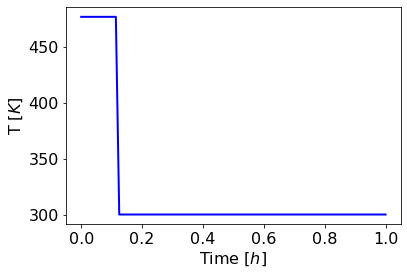

In [10]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('It gives solution:', optimize_result.solution)
print('The log10(OF) optimized is:', optimize_result.obj_value)
print('The result FIM is:', optimize_result.FIM)

t_list = []
for t in optimize_result.model.t:
    t_list.append(t)

T_list = []
for i in t_list:
    T_list.append(value(optimize_result.model.T[i]))

si=16
plt.rc('axes', titlesize=si)
plt.rc('axes', labelsize=si)
plt.rc('xtick', labelsize=si)
plt.rc('ytick', labelsize=si)
plt.rc('legend', fontsize=12)
    
plt.plot(t_list, T_list, 'b', linewidth=2)
#plt.scatter(t_list, T_list, 'b')
plt.ylabel('T [$K$]')
plt.xlabel('Time [$h$]')
plt.show()

## Grid search for 2 design variables

In [11]:
design_ranges = [list(np.linspace(1,5,9)), list(np.linspace(300,700,9))]

dv_apply_name = ['CA0','T']

dv_apply_time = [[0],t_control]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [12]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

81  design vectors will be searched.
=======This is the  1 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.0}, 'T': {0: 300.0, 0.125: 300.0, 0.25: 300.0, 0.375: 300.0, 0.5: 300.0, 0.625: 300.0, 0.75: 300.0, 0.875: 300.0, 1: 300.0}}
Sensitivity information is scaled by its corresponding parameter nominal value.
This run takes wall clock time:  1.1347441673278809  s.
Existed information has been added.
The condition number is: 31972787980626.57 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 0.90110466  0.07362417 -2.80952561 -0.44413588]
 [ 0.07362417  0.72393115 -0.22954992 -4.36711698]
 [-2.80952561 -0.22954992  8.75973063  1.3847538 ]
 [-0.44413588 -4.36711698  1.3847538  26.34464701]]
Trace: 36.729413461228205
Determinant: 4.848608371240737e-22
Condition number: 31965433585094.88
Minimal eigen value: 8.50685168108717e-13
Eigen values: [9.53689322e+00 2.71925202e+01 8.50685168e-13 2.19984061e-12]
Eigen vectors: [[ 0.

This run takes wall clock time:  1.4287991523742676  s.
Existed information has been added.
The condition number is: 138358693491824.11 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 0.1212572   0.08051025 -0.17449118 -0.22415945]
 [ 0.08051025  0.114104   -0.11585565 -0.31769231]
 [-0.17449118 -0.11585565  0.25109578  0.32256936]
 [-0.22415945 -0.31769231  0.32256936  0.88452992]]
Trace: 1.3709869089149331
Determinant: 5.345787902314352e-28
Condition number: 137889898382123.92
Minimal eigen value: 8.75538171889101e-15
Eigen values: [1.20727870e+00 1.63708213e-01 8.75538172e-15 3.11137399e-13]
Eigen vectors: [[ 0.25516385  0.51043383  0.81839598 -0.06785408]
 [ 0.30235023 -0.15114386 -0.07753322 -0.9379192 ]
 [-0.3671852  -0.7345228   0.56871886 -0.04715294]
 [-0.84181398  0.42081956 -0.02784732 -0.33686793]]
This is the  8  run out of  81 run.
The code has run 11.1759 seconds.
Estimated remaining time: 101.9800 seconds
=======This is the  9 th 

This run takes wall clock time:  1.5783569812774658  s.
Existed information has been added.
The condition number is: 199132210297141.9 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 0.42727795  0.26522517 -0.72665305 -0.87271261]
 [ 0.26522517  0.52284848 -0.45105708 -1.72041117]
 [-0.72665305 -0.45105708  1.23578727  1.48418495]
 [-0.87271261 -1.72041117  1.48418495  5.66094141]]
Trace: 7.846855102898291
Determinant: 5.075748439734619e-25
Condition number: 201006166390696.8
Minimal eigen value: 3.389262134493229e-14
Eigen values: [6.81262589e+00 1.03422922e+00 3.38926213e-14 2.12202017e-12]
Eigen vectors: [[-0.16721127  0.47850015  0.86181047 -0.01914375]
 [-0.27449976 -0.09592374 -0.02108036 -0.95655477]
 [ 0.28436901 -0.81376425  0.5067517  -0.01125656]
 [ 0.90323006  0.31563267 -0.00640658 -0.29070566]]
This is the  15  run out of  81 run.
The code has run 21.1996 seconds.
Estimated remaining time: 93.2782 seconds
=======This is the  16 th i

This run takes wall clock time:  1.3738529682159424  s.
Existed information has been added.
The condition number is: 112127370466808.56 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 1.3260611   0.75270966 -2.75632409 -3.02714919]
 [ 0.75270966  2.05300328 -1.56456776 -8.25650167]
 [-2.75632409 -1.56456776  5.72924015  6.29217382]
 [-3.02714919 -8.25650167  6.29217382 33.20492484]]
Trace: 42.31322937680249
Determinant: 1.3443500959505542e-21
Condition number: 111822932733537.47
Minimal eigen value: 3.3076836460019954e-13
Eigen values: [3.69874886e+01 5.32574079e+00 3.30768365e-13 2.06532763e-11]
Eigen vectors: [[-0.1013268  -0.4215274  -0.89916541 -0.0595232 ]
 [-0.23462172  0.05639835  0.0641566  -0.96832994]
 [ 0.21061591  0.87617833 -0.43258642 -0.02863655]
 [ 0.94357112 -0.22681581  0.01595276 -0.24077805]]
This is the  22  run out of  81 run.
The code has run 30.9703 seconds.
Estimated remaining time: 83.0568 seconds
=======This is the  23 

This run takes wall clock time:  1.1131048202514648  s.
Existed information has been added.
The condition number is: 50956035387791.13 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[  4.02388829   1.98764645 -10.75367798 -10.27752407]
 [  1.98764645   7.74469549  -5.31190313 -40.04553812]
 [-10.75367798  -5.31190313  28.73876753  27.46625901]
 [-10.27752407 -40.04553812  27.46625901 207.06367682]]
Trace: 247.57102812051826
Determinant: 4.823050074953349e-19
Condition number: 51020795778927.45
Minimal eigen value: 4.3038137798480985e-12
Eigen values: [2.19584004e+02 2.79870242e+01 4.30381378e-12 1.82183442e-11]
Eigen vectors: [[-0.05532922 -0.34606073 -0.93266094 -0.08497247]
 [-0.18749751  0.02997747  0.08971454 -0.97775841]
 [ 0.14786507  0.92483327 -0.34898972 -0.03179581]
 [ 0.96949434 -0.15500565  0.01735053 -0.18909573]]
This is the  29  run out of  81 run.
The code has run 40.4727 seconds.
Estimated remaining time: 72.5717 seconds
=======Th

This run takes wall clock time:  1.549124002456665  s.
Existed information has been added.
The condition number is: 1127821855853820.0 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 0.59715376  0.38002818 -0.79793482 -0.98251028]
 [ 0.38002818  0.46005653 -0.50780519 -1.1894124 ]
 [-0.79793482 -0.50780519  1.06622452  1.31286006]
 [-0.98251028 -1.1894124   1.31286006  3.07506088]]
Trace: 5.198495694677646
Determinant: 5.7967039251776346e-27
Condition number: 1122717925186380.5
Minimal eigen value: 4.089181773522092e-15
Eigen values: [4.59099768e+00 6.07498018e-01 4.08918177e-15 5.24545296e-13]
Eigen vectors: [[ 0.30847678  0.51365626  0.80048964  0.01508258]
 [ 0.30926344 -0.18572861  0.01710743 -0.93249788]
 [-0.41219601 -0.68636271  0.59906585  0.0112875 ]
 [-0.79955778  0.48017534  0.00661693 -0.36068381]]
This is the  36  run out of  81 run.
The code has run 50.4837 seconds.
Estimated remaining time: 63.1047 seconds
=======This is the  37 th

This run takes wall clock time:  1.3849210739135742  s.
Existed information has been added.
The condition number is: 411714811573923.56 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 1.36188297  0.89530828 -2.12308727 -2.70047739]
 [ 0.89530828  1.49265055 -1.39572795 -4.50221251]
 [-2.12308727 -1.39572795  3.30975542  4.20987033]
 [-2.70047739 -4.50221251  4.20987033 13.57981439]]
Trace: 19.74410333335743
Determinant: 7.640852758703803e-24
Condition number: 410199689285125.5
Minimal eigen value: 4.2114602158539056e-14
Eigen values: [1.72753967e+01 2.46870661e+00 4.21146022e-14 4.31319594e-12]
Eigen vectors: [[ 2.08260428e-01  4.98145715e-01  8.41708495e-01  2.31779652e-03]
 [ 2.90340727e-01 -1.21383294e-01  2.58385595e-03 -9.49189931e-01]
 [-3.24664570e-01 -7.76576692e-01  5.39925364e-01  1.48693360e-03]
 [-8.75741271e-01  3.66122362e-01  8.56570111e-04 -3.14691740e-01]]
This is the  43  run out of  81 run.
The code has run 59.7384 seconds.
Est

This run takes wall clock time:  1.325160026550293  s.
Existed information has been added.
The condition number is: 103712614163112.97 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[  3.01325686   1.75035695  -5.63696653  -6.33542423]
 [  1.75035695   4.07233069  -3.27443307 -14.73981654]
 [ -5.63696653  -3.27443307  10.54519851  11.85182409]
 [ -6.33542423 -14.73981654  11.85182409  53.35082243]]
Trace: 70.98160848723539
Determinant: 9.694114480774225e-21
Condition number: 103856509470543.8
Minimal eigen value: 5.919666386365361e-13
Eigen values: [6.14795888e+01 9.50201968e+00 5.91966639e-13 2.79787160e-11]
Eigen vectors: [[-0.13169739  0.45265632  0.88155488 -0.02486264]
 [-0.25570167 -0.07439479 -0.02719341 -0.96350592]
 [ 0.24636932 -0.84679408  0.4712378  -0.01329036]
 [ 0.92551316  0.26927209 -0.00751308 -0.26619835]]
This is the  50  run out of  81 run.
The code has run 69.0090 seconds.
Estimated remaining time: 42.7856 seconds
=======This

This run takes wall clock time:  1.4076740741729736  s.
Existed information has been added.
The condition number is: 84049708490003.67 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[  7.37064143   4.28925834 -17.23552531 -19.40620044]
 [  4.28925834  13.81787628 -10.03001425 -62.51724657]
 [-17.23552531 -10.03001425  40.30359305  45.3795159 ]
 [-19.40620044 -62.51724657  45.3795159  282.85143392]]
Trace: 344.3435446762198
Determinant: 2.6674131494984245e-18
Condition number: 84078203416734.73
Minimal eigen value: 3.6458788600059765e-12
Eigen values: [3.06538944e+02 3.78046003e+01 3.64587886e-12 6.31134767e-11]
Eigen vectors: [[-0.07535284 -0.38590965 -0.91311868 -0.10766677]
 [-0.21181621  0.04135916  0.114427   -0.96971639]
 [ 0.1762053   0.90241198 -0.39048827 -0.04604304]
 [ 0.95833582 -0.18712504  0.02529125 -0.21433157]]
This is the  57  run out of  81 run.
The code has run 78.5798 seconds.
Estimated remaining time: 33.0862 seconds
=======Th

This run takes wall clock time:  1.1038150787353516  s.
Existed information has been added.
The condition number is: 31962639199564.137 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 18.24736945   1.49088954 -56.89289352  -8.99375163]
 [  1.49088954  14.65960583  -4.64838584 -88.43411871]
 [-56.89289352  -4.64838584 177.3845453   28.04126437]
 [ -8.99375163 -88.43411871  28.04126437 533.47910183]]
Trace: 743.7706224135975
Determinant: 8.154251274460275e-17
Condition number: 31956326451658.17
Minimal eigen value: 1.7231283938455177e-11
Eigen values: [1.93122088e+02 5.50648535e+02 1.72312839e-11 4.44900157e-11]
Eigen vectors: [[ 0.30433403  0.02558873  0.87168401 -0.38461806]
 [-0.01370187  0.16296194 -0.3970782  -0.90248012]
 [-0.94887345 -0.07978216  0.27957687 -0.12335942]
 [ 0.08265733 -0.98306838 -0.06582308 -0.14960293]]
This is the  64  run out of  81 run.
The code has run 88.2301 seconds.
Estimated remaining time: 23.4361 seconds
=======Th

This run takes wall clock time:  1.4510412216186523  s.
Existed information has been added.
The condition number is: 273590817356137.3 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 2.45545822  1.6303325  -3.5334464  -4.53922866]
 [ 1.6303325   2.31060609 -2.34607691 -6.43326909]
 [-3.5334464  -2.34607691  5.08468985  6.53202925]
 [-4.53922866 -6.43326909  6.53202925 17.91172941]]
Trace: 27.762483568972993
Determinant: 3.3670681078681476e-23
Condition number: 272780586018409.44
Minimal eigen value: 8.962291820801459e-14
Eigen values: [2.44473921e+01 3.31509142e+00 8.96229182e-14 4.63687877e-12]
Eigen vectors: [[-0.25516386  0.51043382  0.82116094  0.0064625 ]
 [-0.30235024 -0.15114386  0.00755287 -0.9411084 ]
 [ 0.36718522 -0.73452279  0.57064026  0.00449105]
 [ 0.84181396  0.42081958  0.00271264 -0.33801339]]
This is the  71  run out of  81 run.
The code has run 97.8519 seconds.
Estimated remaining time: 13.7820 seconds
=======This is the  72 t

This run takes wall clock time:  1.4957077503204346  s.
Existed information has been added.
The condition number is: 216982360867551.38 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[  4.74753322   2.94694662  -8.0739233   -9.69680773]
 [  2.94694662   5.80942748  -5.01174556 -19.11567953]
 [ -8.0739233   -5.01174556  13.73097024  16.4909445 ]
 [ -9.69680773 -19.11567953  16.4909445   62.8993485 ]]
Trace: 87.18727944939067
Determinant: 7.249523529159483e-21
Condition number: 214555701517572.3
Minimal eigen value: 3.528027592607731e-13
Eigen values: [7.56958435e+01 1.14914359e+01 3.52802759e-13 2.35860894e-11]
Eigen vectors: [[-0.16721128  0.47850015  0.8617629  -0.02099295]
 [-0.27449976 -0.09592374 -0.02335317 -0.95650697]
 [ 0.28436903 -0.81376424  0.50672374 -0.0123439 ]
 [ 0.90323005  0.31563269 -0.0070973  -0.29069113]]
This is the  78  run out of  81 run.
The code has run 107.2129 seconds.
Estimated remaining time: 4.1236 seconds
=======Thi

### 1D sensitivity curve

Design variable:  ['CA0', 'T']
Value          :  (1.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 350.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 450.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 550.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 650.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 350.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 450.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 550.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 600.0)
Design v

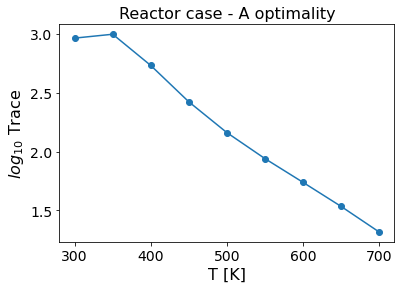

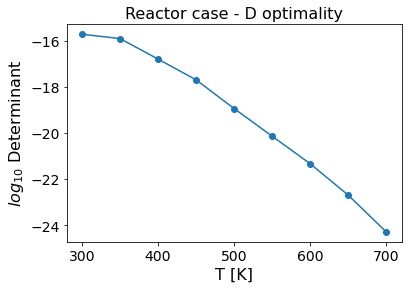

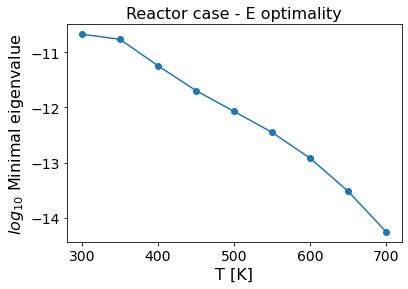

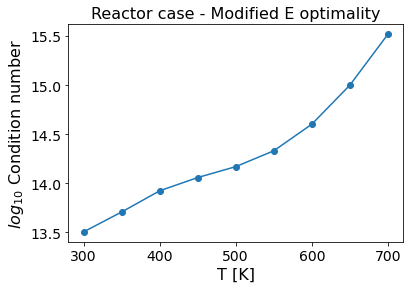

In [13]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

2D heatmap is plotted with  ['CA0', 'T'] .


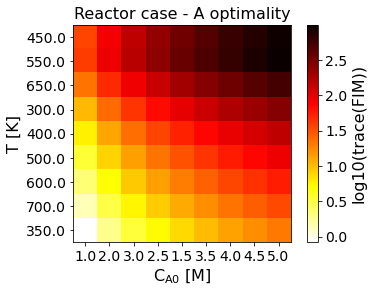

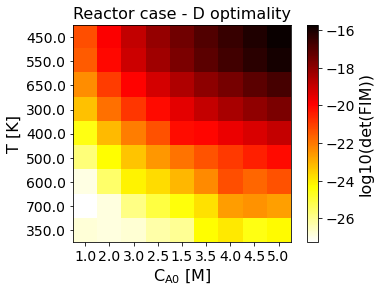

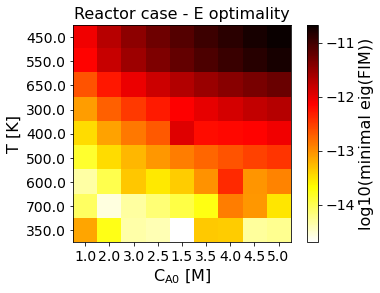

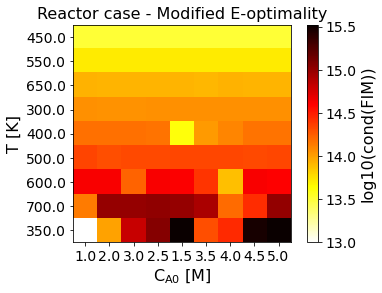

In [14]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [ ]:

#design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

### Draw 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

In [ ]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Dynamic heatmap

In [ ]:
design_ranges = [list(np.linspace(300,700,18))]

dv_apply_name = ['T']

count = 0
for ct in t_control:
    print('Time controlled:', ct)
    dv_apply_time = [[ct]]

    # Define experiments
    exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])
    
    doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

    all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True,
                                     filename = '300base_'+str(count)+'.csv'
                                    )
    
    test = all_fim.extract_criteria()

    ## draw 1D sensitivity curve 

    fixed = {}

    all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )
    count += 1 

In [ ]:
filename_list = []
count = 0
for ct in t_control:
    print('Time controlled:', ct)
    filename_list.append('300base_'+str(count)+'.csv')
    count += 1
    
print(filename_list)

data_list = []
for i in filename_list:
    data_list.append(pd.read_csv(i))
print(np.shape(data_list))

In [ ]:
print(data_list[3]['D'].iloc[4])

In [ ]:
d_result = np.zeros((18,8))

for i in range(8):
    for j in range(18):
        d_result[j,i] = np.log10(data_list[i]['ME'].iloc[j])
        
print(d_result)

In [ ]:
x_range1 = [0,0.125,0.25,0.375,0.5,0.625,0.75,0.875]
x_range1 = [0,0.13, 0.25,0.38,0.5,0.63,0.75,0.88]
y_range1 = yLabel = [300, 321, 342, 363, 384, 405, 426, 447, 468, 489, 511, 532, 553, 574, 595, 616, 637, 658, 679, 700.0]

heatmap(x_range1, y_range1, 'Time [$h$]', 'Temperature [$K$]')

In [ ]:
import matplotlib.ticker as ticker
def heatmap(x_range, y_range, xlabel_text, ylabel_text, font_axes=16, font_tick=12, log_scale=True):
    '''
    Draw 2D heatmaps for all design criteria

    Parameters:
    ----------
    title_text: name of the figure, a string
    xlabel_text: x label title, a string.
        In a 2D heatmap, it should be the second design varialbe in the design_ranges
    ylabel_text: y label title, a string.
        In a 2D heatmap, it should be the first design variable in the dv_ranges
    font_axes: axes label font size
    font_tick: tick label font size
    log_scale: if True, the result matrix will be scaled by log10

    Returns:
    --------
    4 Figures of 2D heatmap for each criteria
    '''
    # set heatmap x,y ranges
    xLabel = x_range
    yLabel = y_range

    # D-optimality
    fig = plt.figure()
    plt.rc('axes', titlesize=font_axes)
    plt.rc('axes', labelsize=font_axes)
    plt.rc('xtick', labelsize=font_tick)
    plt.rc('ytick', labelsize=font_tick)
    ax = fig.add_subplot(111)
    params = {'mathtext.default': 'regular'}
    plt.rcParams.update(params)
    ax.set_yticks(range(len(yLabel)))
    ax.set_yticklabels(yLabel)
    ax.set_ylabel(ylabel_text)
    
    
    ax.set_xticks(range(len(xLabel)))
    ax.set_xticklabels(xLabel)
    loc = ticker.MultipleLocator(base=2)
    ax.xaxis.set_major_locator(loc)
    ax.set_xlabel(xlabel_text)

    im = ax.imshow(d_result, cmap=plt.cm.hot_r)
    ba = plt.colorbar(im)
    ba.set_label('$log_{10}$(ME-optimality)',labelpad=-40, y=1.1, rotation=0)
    plt.show()
